# Unit 2 - Open Loop Identification - Measurement of Frequency Response Functions - Periodic Excitation

# Objective

Previous lecture we learned how averaging is a handy tool when reducing the variance and bias of an estimate.

The fact that the reference signal was periodic enabled this result. 

Recall that the reference consisted of just a single sinusoid. Thus to construct an estimate of the Frequency Response Function (FRF) at 50 different frequency points, 50 separate experiments were required. 

It is rather slow to excite a real system with 50 (or more) different sinusoids, and do repeated measurements for each sinusoid. 

In this lecture, we will show how to combine all these experiments into one single experiment. The key will be use use multi-sine reference signals. 

# Activity

Before continuing skim sections 5.3.1 and 5.3.2 in the book "System Identification: A Frequency Domain Approach" by Rik Pintelon.  

# Recall: Open Loop Measurement Setup

![OpenLoop](open-loop-EIV.png "Open Loop")

# Do all experiments simultaneously

Idea: construct a reference signal that is just a sum of all the sinusoids:

$$
r(t) = \sum_{p=0}^{P} \sin(2\pi f_pt) 
$$

# Activity

Construct this signal in code. Plot the result. What do you notice?

Experiment with different values of $P$ and $N$. 

What is the period of $r$?

Text(0.5, 0, 'Frequency (rad/s)')

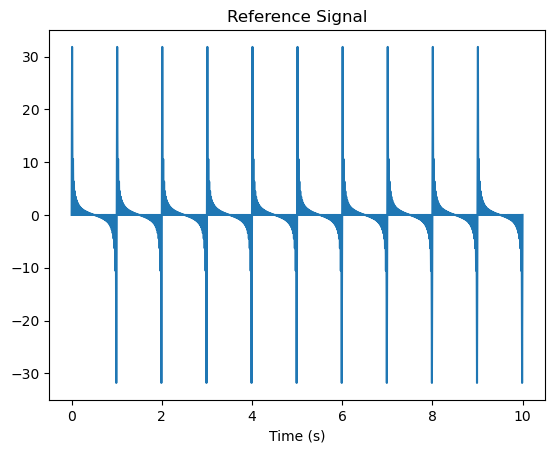

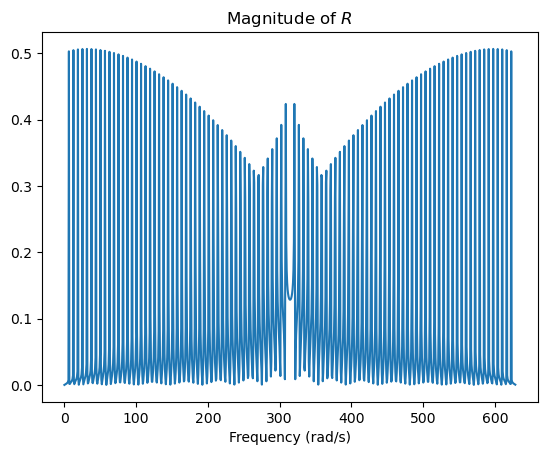

In [4]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

N = 1001
t = np.linspace(0,10,N)
P = 50
f_vec = np.linspace(1,P,P)
r_multisine = np.zeros(N)
for f in f_vec:
    r_multisine += np.sin(2*np.pi*f*t) 


fig,ax=plt.subplots(1)
ax.plot(t,r_multisine)
ax.set_title('Reference Signal')
ax.set_xlabel('Time (s)')

Ts = t[1]-t[0]
fs = 1/Ts
w = np.linspace(0,2*np.pi*fs,N)
fig,ax=plt.subplots(1)
ax.plot(w,np.abs(np.fft.fft(r_multisine))/N)
ax.set_title('Magnitude of $R$')
ax.set_xlabel('Frequency (rad/s)')


# Question

If we applied this reference signal to a system, at which frequencies would we expect the estimated model to be valid?

# The Problem

Assume that the noise is constant over time. If the reference signal is very small for a period of time, the signal to noise ratio will be relatively small for that time. This could lead to degradation in the data. 

The problem with the reference signal designed in the previous cell is that the magnitude is very large for a short period of time, and then very small for a large period of time. This means that the signal to noise ratio, for most of the time is relatively small. 

The *crest factor* of a signal is the ratio of the maximum of the signal and its average:
$$
C(r) = \frac{r_{\text{peak}}}{r_{\text{rms}}},
$$
where 
- $r_{\text{peak}}$ is the max absolute value of of $r$, and 
- $r_{\text{rms}}$ is the root mean square of $r$, defined as $r_{\text{rms}} = \sqrt{\frac{1}{N}\sum_{t=0}^{N-1}r^2(t)}$

It is better to have a reference signal with a relatively constant envelope, i.e. a small crest factor.



# Activity

What is the crest factor of the signals you generated in the previous code block?

# Schroeder Multisine

The Schroeder Multisine aims to reduce the crest factor of $r$.

It is defined as:
$$
r(t) = \sum_{p=1}^{P} A \cos(2\pi f_pt + \phi_p),
$$
where 
$$
\begin{align*}
\phi_k &= -p(p-1)\pi/P, \\
f_k &= \ell_k f_0
\end{align*}
$$


# Activity

Write some code to construct a Schroeder Multisine. Compare the time and frequency domain plots with the multisine constructed in the beginning of this lecture.

Text(0.5, 0, 'Frequency (rad/s)')

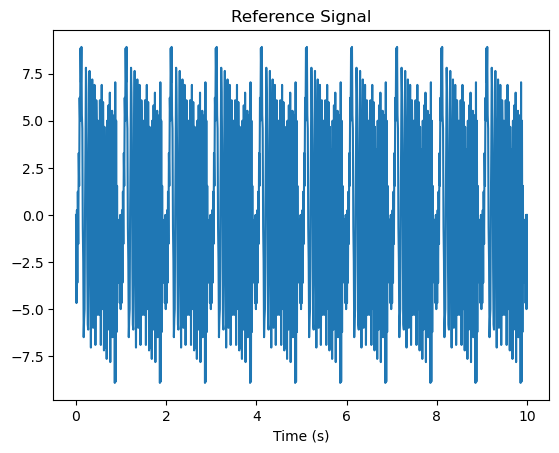

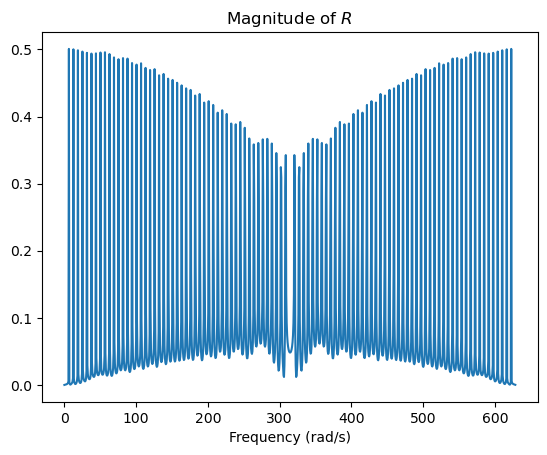

In [3]:
import control as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

N = 1001
t = np.linspace(0,10,N)
P = 50
f_vec = np.linspace(1,P,P)
r_schroeder = np.zeros(N)
p = 1
for f in f_vec:
    phi = -p*(p-1)*np.pi/P
    r_schroeder += np.sin(2*np.pi*f*t + phi)
    p += 1


fig,ax=plt.subplots(1)
ax.plot(t,r_schroeder)
ax.set_title('Reference Signal')
ax.set_xlabel('Time (s)')

Ts = t[1]-t[0]
fs = 1/Ts
w = np.linspace(0,2*np.pi*fs,N)
fig,ax=plt.subplots(1)
ax.plot(w,np.abs(np.fft.fft(r_schroeder))/N)
ax.set_title('Magnitude of $R$')
ax.set_xlabel('Frequency (rad/s)')


What is the crest factor of the Shroeder Multisine that you constructed?

# Activity

Estimate the same transfer function as last lecture, but using a multisine, instead of many sinusoids.

Compare the estimate for a Multisine (where each sinusoid has the same phase) and a Schroeder Multisine.

What do you notice? How do the two estimates compare?

trial 0


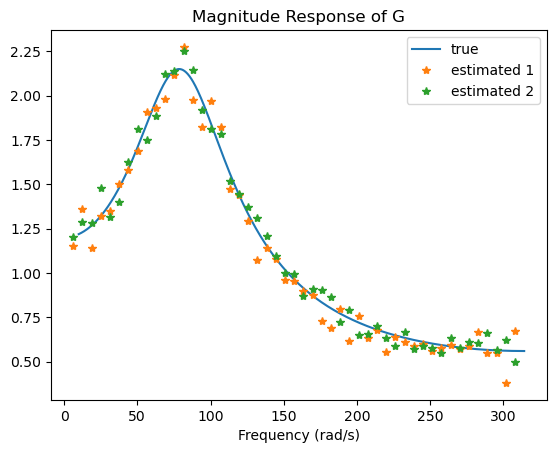

In [5]:
N = 1001
t = np.linspace(0,10,N)


Ts = t[1]-t[0]
G = ct.tf([1, -0.4], [1, -1, 0.5], Ts)

fs = 1/Ts

b, a = sp.signal.butter(6, 0.5, 'low')

R_multisine = np.fft.fft(r_multisine)
R_schroeder = np.fft.fft(r_schroeder)

nf = 50
num_trials = 1
M_u = 1
M_y = 1
G_hat_multisine = np.empty((nf,num_trials),dtype=complex)
G_hat_schroeder = np.empty((nf,num_trials),dtype=complex)
for trial in range(num_trials):
    print('trial', trial)
    u_multisine = r_multisine + M_u*sp.signal.lfilter(b, a, M_u*np.random.randn(N))
    u_schroeder = r_schroeder + M_u*sp.signal.lfilter(b, a, M_u*np.random.randn(N))
    tt,y_multisine = ct.forced_response(G,U=r_multisine) + M_y*np.random.randn(N)
    tt,y_schroeder = ct.forced_response(G,U=r_schroeder) + M_y*np.random.randn(N)
    Y_multisine = np.fft.fft(y_multisine)
    Y_schroeder = np.fft.fft(y_schroeder)
    U_multisine = np.fft.fft(u_multisine)
    U_schroeder = np.fft.fft(u_schroeder)
     
    for f in range(1,nf):
       G_hat_multisine[f-1,trial] = Y_multisine[int(N/fs*f)]/U_multisine[int(N/fs*f)]
       G_hat_schroeder[f-1,trial] = Y_schroeder[int(N/fs*f)]/U_schroeder[int(N/fs*f)]
    

G_hat_mean_multisine = np.mean(G_hat_multisine,axis=1)
G_hat_mean_schroeder = np.mean(G_hat_schroeder,axis=1)

mag,phase,w1 = ct.bode_plot(G,plot=False)

w2 = np.linspace(1,nf)*2*np.pi
fig,ax = plt.subplots(1)
ax.plot(w1,mag,label='true')
ax.plot(w2[0:nf-1],abs(G_hat_mean_multisine[0:nf-1]),'*',label='estimated 1')
ax.plot(w2[0:nf-1],abs(G_hat_mean_schroeder[0:nf-1]),'*',label='estimated 2')
ax.set_title('Magnitude Response of G')
ax.set_xlabel('Frequency (rad/s)')
ax.legend()



